# Final Project:
The first dataset that we have chosen is the one provided in a hackathon called BitCamp-2024 which was held at the University of Maryland College Park. The dataset contains information about loan repayments and loan defaults. The Second dataset contains various storm event datas. We had to change the second data set as the one proposed in the project proposal has very less precision. The data set we have chosen now has high precision.

**Source of the Dataset:**

**Dataset 1:** Cities from the United States
https://www.dropbox.com/scl/fo/zz1z8f60jff7qb4fbtgwx/AK7KLy9Y3xsyjlnA1ej4BUU?rlkey=kgud7i32e1k60dkwkc7hryyd0&st=r6ce4am8&dl=0 ( focusing on the cities from Florida: Miami, Tallahassee, Tampa)


**Size of the Dataset Includes:**

Miami- 8,43,623 Rows & 29 Columns  
Tallahassee: 40,707 Rows & 29 Columns  
Tampa: 3,98,227 Rows& 29 Columns



**Dataset 2:** Storm Event Database
https://www.ncdc.noaa.gov/stormevents/choosedates.jsp?statefips=12%2CFLORIDA#

State: Florida  
County: Hillsborough, Miami-Dade, Leon  
Begin date: 1/2/1999   
End Date: 1/2/2024   
Event Types: All Events   

**In Advanced search filter**

Hail Filter: Hail 4.00 in. and larger  
Tornado Filter: Tornado F5/EF5 only   
Wind Filter: Wind 50 kts. and stronger

(Note: At a time only 500 rows can be downloaded from the website, hence we downloaded multiple cvs files with 500 rows each (7 csv files) and concatnated it)

Size of the Dataset Includes:
Total 2790 rows and 39 columns


 **Note:** We have mounted the whole data set into google drive and shared aacces to the professor (jhwan@umbc.edu)

 **Teammates:**

(1) Sashank Gandikota    
(2) Sherin Feno Kumaresan  
(3) Vishnu Vikas Nallamalli   
(4) Digvijay Singh  
(5) Adityaa Venkataraman

In [ ]:
# Importing necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import plotly.graph_objects as go
import plotly.express as px

In [ ]:


def read_multiple_csv_from_links(file_tuples):
    """
    Read multiple CSV files from the google drive links into pandas DataFrames.

    Parameters:
    - file_tuples: list of tuples, each tuple containing the file name and its corresponding link.

    Returns:
    - dfs: dict of pandas DataFrames, containing the data from the CSV files.
    """
    dfs = {}
    for file_name, file_link in file_tuples:
        try:
            df = pd.read_csv(file_link, encoding='utf-8')
            print(f"CSV file '{file_name}' read successfully.")
            dfs[file_name] = df
        except FileNotFoundError:
            print(f"Error: CSV file '{file_name}' not found.")
        except pd.errors.ParserError:
            print(f"Error: Unable to parse CSV file '{file_name}'.")
        except Exception as e:
            print(f"Unexpected error: {e}")
    return dfs

# List of tuples containing file names and publicly accessible CSV file links
csv_file_tuples = [
    ('tampa', '/content/drive/Shareddrives/Dataset/tampa.csv'),
    ('miami', '/content/drive/Shareddrives/Dataset/miami.csv'),
    ('tallahassee', '/content/drive/Shareddrives/Dataset/tallahassee.csv')
]

# Read multiple CSV files into DataFrames
dataframes_dict = read_multiple_csv_from_links(csv_file_tuples)

# Assign DataFrames to separate variables
tampa_df = dataframes_dict.get('tampa')
miami_df = dataframes_dict.get('miami')
tallahassee_df = dataframes_dict.get('tallahassee')

CSV file 'tampa' read successfully.
CSV file 'miami' read successfully.
CSV file 'tallahassee' read successfully.


In [ ]:
# Adding a new column called city and entering the respective city name into that column.
miami_df['City'] = "Miami"
tallahassee_df['City'] = "Tallahassee"
tampa_df['City'] = "Tampa"

In [ ]:
# Keeping the dataframes inside a list
dfs = [miami_df, tallahassee_df, tampa_df]

In [ ]:
# Defining a function to Preprocess the data
def preprocess_data(df):

    # Replace numeric codes with descriptive strings in 'Zero_Balance_Code'
    df['Zero_Balance_Code'] = df['Zero_Balance_Code'].replace({
        1: "Prepaid or Matured",
        2: "Third Party Sale",
        3: "Short Sale",
        6: "Repurchased",
        9: "Deed-in-Lieu; REO Disposition",
        15: "Notes Sales",
        96: "Removal (non-credit event)",
        97: "Delinquency (credit event due to D180)",
        98: "Other Credit Event"
    })

    # Replace missing credit scores with 'Unknown'
    df['Borrower_Credit_Score'].fillna('Unknown', inplace=True)
    df.loc[df['Number_of_Borrowers'] > 1, 'Co_borrower_credit_score'].fillna('Unknown', inplace=True)
    df.loc[df['Number_of_Borrowers'] == 1, 'Co_borrower_credit_score'].fillna('N/A', inplace=True)

    # Convert columns to datetime format
    date_columns = ['Foreclosure_date', 'Zero_Balance_Effective_Date', 'Last_paid_installment_date']
    for column in date_columns:
        df[column] = pd.to_datetime(df[column], format='%m%Y', errors='coerce')
    # Remove duplicates from the 'seller_name' column
    unique_sellers_df = df.drop_duplicates(subset=['Seller_Name'])

    # Convert 'Interest_Only_Loan' indicator to 'Yes'/'No'
    df['Interest_Only_Loan'] = df['Interest_Only_Loan'].map({'Y': 'Yes', 'N': 'No'})

    # Replace loan purpose codes with descriptive strings
    df['Loan_Purpose'] = df['Loan_Purpose'].replace({
        "C": "Cash-Out Refinance",
        "R": "Refinance",
        "U": "Refinance-Not Specified",
        "P": "Purchase"
    })

    # Drop unnecessary columns
    columns_to_drop = ['Loan_Identifier', 'Servicer_Name', 'Original_UPB','Seller_Name']
    df.drop(columns=columns_to_drop, inplace=True)

    return df
# List to store processed DataFrames
dfd = []

# Processing each file individually
for df in dfs:
    processed_df = preprocess_data(df)
    dfd.append(processed_df)

# Concatenating the DataFrames
result_df = pd.concat(dfd, ignore_index=True)

In [ ]:
def clean_dataframe_by_nulls(df, column_to_check, verbose=True):
  """
  This function cleans a DataFrame by removing rows where a specific column
  contains missing values (null values). The main focus of this analysis revolves around the loans that are forclosed.
  So Focusing only on loans that actually have foreclosure dates recorded.

  Args:
      df (pandas.DataFrame): The DataFrame you want to clean.
      column_to_check (str): The name of the column containing potentially missing dates.
          For example, 'Foreclosure_date'.
      verbose (bool, optional): Whether to print information about the cleaning process.
          Defaults to True, providing details about dropped rows.

  Returns:
      pandas.DataFrame: A new DataFrame with rows containing missing foreclosure dates removed.

  Raises:
      ValueError: If the specified column is not found in the DataFrame.
  """

  if column_to_check not in df.columns:
    raise ValueError(f"Column '{column_to_check}' not found in the DataFrame.")

  cleaned_df = df.dropna(subset=[column_to_check])

  if verbose:
    num_dropped_rows = len(df) - len(cleaned_df)
    print(f"Focused on Foreclosures: {len(cleaned_df)} loans were selected into cleaned data frame.")

  return cleaned_df

# Executing the defined function
cleaned_df = clean_dataframe_by_nulls(result_df, 'Foreclosure_date')

Focused on Foreclosures: 31477 loans were selected into cleaned data frame.


In [ ]:
cleaned_df.shape

(31477, 26)

In [ ]:
cleaned_df.head(5)

,PayYear,PayMonth,OriginationYear,OriginationMonth,Original_Interest_Rate,Current_Interest_Rate,Original_Loan_Term,Maturity_Month,Maturity_Year,Original_LTV,Number_of_Borrowers,DTI,Borrower_Credit_Score,Co_borrower_credit_score,Loan_Purpose,Property_State,MSA,Zip_Code_Short,Amoritization_Type,Interest_Only_Loan,Zero_Balance_Code,Zero_Balance_Effective_Date,Last_paid_installment_date,Foreclosure_date,Foreclosure_costs,City
57,2013,11,2005,5,5.875,NaN,0.0,NaN,NaN,80,2.0,36.0,643.0,674.0,Cash-Out Refinance,FL,33100,330,FRM,No,Short Sale,2013-11-01,2013-05-01,2013-11-01,62013.0,Miami
79,2011,3,2006,8,6.875,NaN,0.0,NaN,NaN,70,2.0,35.0,666.0,750.0,Cash-Out Refinance,FL,33100,333,FRM,No,Short Sale,2011-03-01,2010-06-01,2011-03-01,32011.0,Miami
145,2014,6,2005,5,6.375,NaN,0.0,NaN,NaN,97,1.0,52.0,679.0,NaN,Purchase,FL,33100,334,FRM,No,Deed-in-Lieu; REO Disposition,2014-06-01,2009-03-01,2014-06-01,92014.0,Miami
171,2013,12,2007,5,6.875,NaN,0.0,NaN,NaN,80,2.0,46.0,642.0,635.0,Cash-Out Refinance,FL,33100,330,FRM,No,Deed-in-Lieu; REO Disposition,2013-12-01,2009-04-01,2013-12-01,82014.0,Miami
269,2012,2,2007,10,6.500,NaN,0.0,NaN,NaN,80,1.0,25.0,632.0,NaN,Purchase,FL,33100,331,FRM,No,Deed-in-Lieu; REO Disposition,2012-02-01,2011-10-01,2012-02-01,72012.0,Miami


# Climate Data

   The extreme climate data is taken from the below link. Due to the limitation that only 500 rows can be downloaded at a single time we have downloaded multiple csv files date starting from 1/2/1999  to 1/2/2024 .

   Link: https://www.ncdc.noaa.gov/stormevents/choosedates.jsp?statefips=12%2CFLORIDA#

In [ ]:
# List of CSV file in the google drive.
file_names = [
    "/content/drive/Shareddrives/Dataset/storm_data_search_results.csv",
    "/content/drive/Shareddrives/Dataset/storm_data_search_results-2.csv",
    "/content/drive/Shareddrives/Dataset/storm_data_search_results-3.csv",
    "/content/drive/Shareddrives/Dataset/storm_data_search_results-4.csv",
    "/content/drive/Shareddrives/Dataset/storm_data_search_results-5.csv",
    "/content/drive/Shareddrives/Dataset/storm_data_search_results-6.csv",
    "/content/drive/Shareddrives/Dataset/storm_data_search_results-7.csv"
]

# List to store DataFrames
ds = []

# Iterate over CSV files in the list
for filename in file_names:
    if filename.endswith('.csv'):
        try:
            # Read CSV file into a DataFrame and append to the list
            ds.append(pd.read_csv(filename, on_bad_lines='skip'))
        except pd.errors.ParserError as e:
            print(f"Error parsing {filename}: {e}")

# Concatenate all DataFrames in the list

concta_result = pd.concat(ds, ignore_index=True)



In [ ]:
concta_result.head()

,EVENT_ID,CZ_NAME_STR,BEGIN_LOCATION,BEGIN_DATE,BEGIN_TIME,EVENT_TYPE,MAGNITUDE,TOR_F_SCALE,DEATHS_DIRECT,INJURIES_DIRECT,DAMAGE_PROPERTY_NUM,DAMAGE_CROPS_NUM,STATE_ABBR,CZ_TIMEZONE,MAGNITUDE_TYPE,EPISODE_ID,CZ_TYPE,CZ_FIPS,WFO,INJURIES_INDIRECT,DEATHS_INDIRECT,SOURCE,FLOOD_CAUSE,TOR_LENGTH,TOR_WIDTH,BEGIN_RANGE,BEGIN_AZIMUTH,END_RANGE,END_AZIMUTH,END_LOCATION,END_DATE,END_TIME,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EVENT_NARRATIVE,EPISODE_NARRATIVE,ABSOLUTE_ROWNUMBER
0,5682276,HILLSBOROUGH CO.,APOLLO BEACH,01/02/1999,2200.0,Storm Surge/Tide,,,0.0,0.0,0.0,0.0,FL,EST,,1500136.0,C,57.0,TBW,0.0,0.0,EMERGENCY MANAGER,,,,,,,,APOLLO BEACH,01/03/1999,300.0,,,,,NaN,"Storm surge, partly enhanced by a fast moving ...",1.0
1,5683994,HILLSBOROUGH CO.,TAMPA,01/02/1999,2322.0,Tornado,,F1,0.0,1.0,150000.0,0.0,FL,EST,,1501955.0,C,57.0,TBW,0.0,0.0,NWS STORM SURVEY,,2.3,10,9,SE,9,SE,TAMPA,01/02/1999,2325.0,27.88,-82.37,27.88,-82.37,A National Weather Service damage survey concl...,NaN,2.0
2,5683995,HILLSBOROUGH CO.,APOLLO BEACH,01/02/1999,2330.0,Thunderstorm Wind,50,,0.0,0.0,10000.0,0.0,FL,EST,EG,1502920.0,C,57.0,TBW,0.0,0.0,GENERAL PUBLIC,,,,,,,,APOLLO BEACH,01/02/1999,2330.0,27.75,-82.43,27.75,-82.43,Thunderstorm wind gusts destroyed a screened p...,NaN,3.0
3,5682134,HILLSBOROUGH CO.,TAMPA,01/02/1999,2335.0,Tornado,,F1,0.0,0.0,150000.0,0.0,FL,EST,,1500135.0,C,57.0,TBW,0.0,0.0,UTILITY COMPANY,,.2,100,22,E,22,E,TAMPA,01/02/1999,2335.0,27.98,-82.12,27.98,-82.12,"A tornado touched down along County Road 39, a...",NaN,4.0
4,5679348,MIAMI-DADE CO.,WESTCHESTER,01/03/1999,418.0,Thunderstorm Wind,60,,0.0,0.0,0.0,0.0,FL,EST,,1500947.0,C,86.0,MFL,0.0,0.0,BROADCAST MEDIA,,,,,,,,WESTCHESTER,01/03/1999,418.0,25.75,-80.3,25.75,-80.3,Thunderstorm winds blew down trees in Westches...,NaN,5.0


In [ ]:
concta_result.shape

(2790, 39)

In [ ]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Selecting only the rows containing disaster starting around the three cities.
tallahassee_data = concta_result[concta_result["BEGIN_LOCATION"].str.contains("Tallahassee", case=False, na=False)]
# Print the filtered DataFrame
print(tallahassee_data)

miami_data = concta_result[concta_result["BEGIN_LOCATION"].str.contains("Miami", case=False, na=False)]
# Print the filtered DataFrame
print(miami_data)

tampa_data = concta_result[concta_result["BEGIN_LOCATION"].str.contains("Tampa", case=False, na=False)]
# Print the filtered DataFrame
print(tampa_data)

Streaming output truncated to the last 5000 lines.
363                                                                   
364                                                              15   
365                                                                   
427                                                               7   
455                                                                   
469                                                                   
500                                                                   
501                                                                   
516                                                                   
517                                                                   
520                                                              15   
526                                                               7   
553                                                               7   
554                       

In [ ]:
# Concatenate the filtered DataFrames into a single DataFrame
Extreme_climate_df = pd.concat([tallahassee_data, miami_data, tampa_data], ignore_index=True)

In [ ]:
# Selecting only the necessary columns
filtered_columns_df = Extreme_climate_df[["CZ_NAME_STR", "BEGIN_LOCATION", "BEGIN_DATE","EVENT_TYPE","DEATHS_DIRECT"]]

# Print the filtered DataFrame
print(filtered_columns_df)

          CZ_NAME_STR                 BEGIN_LOCATION  BEGIN_DATE  \
0            LEON CO.                    TALLAHASSEE  06/04/1999   
1            LEON CO.                    TALLAHASSEE  06/04/1999   
2            LEON CO.                    TALLAHASSEE  06/04/1999   
3            LEON CO.                    TALLAHASSEE  06/04/1999   
4            LEON CO.                    TALLAHASSEE  08/13/1999   
5            LEON CO.                    TALLAHASSEE  08/14/1999   
6            LEON CO.                    TALLAHASSEE  01/24/2000   
7            LEON CO.                    TALLAHASSEE  02/14/2000   
8            LEON CO.                    TALLAHASSEE  02/14/2000   
9            LEON CO.                    TALLAHASSEE  03/16/2000   
10           LEON CO.                    TALLAHASSEE  03/16/2000   
11           LEON CO.                    TALLAHASSEE  06/17/2000   
12           LEON CO.                    TALLAHASSEE  07/14/2000   
13           LEON CO.                    TALLAHA

In [ ]:
# Converting the begin date to date time format
filtered_columns_df['BEGIN_DATE'] = pd.to_datetime(filtered_columns_df['BEGIN_DATE'])
filtered_columns_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CZ_NAME_STR     624 non-null    object        
 1   BEGIN_LOCATION  624 non-null    object        
 2   BEGIN_DATE      624 non-null    datetime64[ns]
 3   EVENT_TYPE      624 non-null    object        
 4   DEATHS_DIRECT   624 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 24.5+ KB


<ipython-input-133-14a2edc5d67e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
filtered_columns_df.head(5)

,CZ_NAME_STR,BEGIN_LOCATION,BEGIN_DATE,EVENT_TYPE,DEATHS_DIRECT
0,LEON CO.,TALLAHASSEE,1999-06-04,Hail,0.0
1,LEON CO.,TALLAHASSEE,1999-06-04,Hail,0.0
2,LEON CO.,TALLAHASSEE,1999-06-04,Hail,0.0
3,LEON CO.,TALLAHASSEE,1999-06-04,Thunderstorm Wind,0.0
4,LEON CO.,TALLAHASSEE,1999-08-13,Thunderstorm Wind,0.0


# Note: A mortgage considered as stressed assert if the loan repayment was not be done for 120 days(4 months).Based on this we are keeping a buffer date of four months from the Begin date of Extreme Weather.

In [ ]:
# Add 4 months to the "BEGIN_DATE" to create the "range" column
filtered_columns_df.loc[:, 'range'] = filtered_columns_df['BEGIN_DATE'] + pd.DateOffset(months=4)

# Print the DataFrame to verify the changes
print(filtered_columns_df)

          CZ_NAME_STR                 BEGIN_LOCATION BEGIN_DATE  \
0            LEON CO.                    TALLAHASSEE 1999-06-04   
1            LEON CO.                    TALLAHASSEE 1999-06-04   
2            LEON CO.                    TALLAHASSEE 1999-06-04   
3            LEON CO.                    TALLAHASSEE 1999-06-04   
4            LEON CO.                    TALLAHASSEE 1999-08-13   
5            LEON CO.                    TALLAHASSEE 1999-08-14   
6            LEON CO.                    TALLAHASSEE 2000-01-24   
7            LEON CO.                    TALLAHASSEE 2000-02-14   
8            LEON CO.                    TALLAHASSEE 2000-02-14   
9            LEON CO.                    TALLAHASSEE 2000-03-16   
10           LEON CO.                    TALLAHASSEE 2000-03-16   
11           LEON CO.                    TALLAHASSEE 2000-06-17   
12           LEON CO.                    TALLAHASSEE 2000-07-14   
13           LEON CO.                    TALLAHASSEE 2000-07-2

<ipython-input-135-48122df896c6>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
filtered_columns_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CZ_NAME_STR     624 non-null    object        
 1   BEGIN_LOCATION  624 non-null    object        
 2   BEGIN_DATE      624 non-null    datetime64[ns]
 3   EVENT_TYPE      624 non-null    object        
 4   DEATHS_DIRECT   624 non-null    float64       
 5   range           624 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 29.4+ KB


In [ ]:
filtered_columns_df.head()

,CZ_NAME_STR,BEGIN_LOCATION,BEGIN_DATE,EVENT_TYPE,DEATHS_DIRECT,range
0,LEON CO.,TALLAHASSEE,1999-06-04,Hail,0.0,1999-10-04
1,LEON CO.,TALLAHASSEE,1999-06-04,Hail,0.0,1999-10-04
2,LEON CO.,TALLAHASSEE,1999-06-04,Hail,0.0,1999-10-04
3,LEON CO.,TALLAHASSEE,1999-06-04,Thunderstorm Wind,0.0,1999-10-04
4,LEON CO.,TALLAHASSEE,1999-08-13,Thunderstorm Wind,0.0,1999-12-13


In [ ]:
# We are joining both the data sets
# if the forclosure date is between the range and begin date of the disaster, then we assume that the forclosure of loan is caused by the extreme climate event.
# If the forclosure date is between the range and begin date, then we enter the disaster type in a new column on the cleaned_df.

for index, row in cleaned_df.iterrows():
    filtered_df1 = filtered_columns_df[
        (filtered_columns_df['BEGIN_DATE'] <= row['Foreclosure_date']) &
        (filtered_columns_df['range'] >= row['Foreclosure_date'])
    ]


    if not filtered_df1.empty:
        disaster_type = filtered_df1.iloc[0]['EVENT_TYPE']
        cleaned_df.at[index, 'Disaster_Type'] = disaster_type

  # Now we have only the forclosed loan data that is caused by climate disaster in the cleaned_df

<ipython-input-138-1f18e9a6c025>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:

cleaned_df.shape

(31477, 27)

In [ ]:
cleaned_df.head(10)

,PayYear,PayMonth,OriginationYear,OriginationMonth,Original_Interest_Rate,Current_Interest_Rate,Original_Loan_Term,Maturity_Month,Maturity_Year,Original_LTV,Number_of_Borrowers,DTI,Borrower_Credit_Score,Co_borrower_credit_score,Loan_Purpose,Property_State,MSA,Zip_Code_Short,Amoritization_Type,Interest_Only_Loan,Zero_Balance_Code,Zero_Balance_Effective_Date,Last_paid_installment_date,Foreclosure_date,Foreclosure_costs,City,Disaster_Type
57,2013,11,2005,5,5.875,NaN,0.0,NaN,NaN,80,2.0,36.0,643.0,674.0,Cash-Out Refinance,FL,33100,330,FRM,No,Short Sale,2013-11-01,2013-05-01,2013-11-01,62013.0,Miami,Flash Flood
79,2011,3,2006,8,6.875,NaN,0.0,NaN,NaN,70,2.0,35.0,666.0,750.0,Cash-Out Refinance,FL,33100,333,FRM,No,Short Sale,2011-03-01,2010-06-01,2011-03-01,32011.0,Miami,NaN
145,2014,6,2005,5,6.375,NaN,0.0,NaN,NaN,97,1.0,52.0,679.0,NaN,Purchase,FL,33100,334,FRM,No,Deed-in-Lieu; REO Disposition,2014-06-01,2009-03-01,2014-06-01,92014.0,Miami,Lightning
171,2013,12,2007,5,6.875,NaN,0.0,NaN,NaN,80,2.0,46.0,642.0,635.0,Cash-Out Refinance,FL,33100,330,FRM,No,Deed-in-Lieu; REO Disposition,2013-12-01,2009-04-01,2013-12-01,82014.0,Miami,Thunderstorm Wind
269,2012,2,2007,10,6.500,NaN,0.0,NaN,NaN,80,1.0,25.0,632.0,NaN,Purchase,FL,33100,331,FRM,No,Deed-in-Lieu; REO Disposition,2012-02-01,2011-10-01,2012-02-01,72012.0,Miami,Heavy Rain
273,2010,8,2007,9,6.750,NaN,0.0,NaN,NaN,80,1.0,49.0,698.0,NaN,Cash-Out Refinance,FL,33100,334,FRM,No,Short Sale,2010-08-01,2009-12-01,2010-08-01,92010.0,Miami,Thunderstorm Wind
359,2015,5,2006,7,5.990,NaN,0.0,NaN,NaN,80,1.0,37.0,608.0,NaN,Purchase,FL,33100,331,FRM,No,Deed-in-Lieu; REO Disposition,2015-05-01,2011-10-01,2015-05-01,122016.0,Miami,Tornado
435,2018,2,2005,9,6.125,NaN,0.0,NaN,NaN,75,1.0,49.0,673.0,NaN,Cash-Out Refinance,FL,33100,334,FRM,No,Third Party Sale,2018-02-01,2012-04-01,2018-01-01,12018.0,Miami,NaN
471,2013,7,2005,9,6.375,NaN,0.0,NaN,NaN,74,1.0,56.0,605.0,NaN,Cash-Out Refinance,FL,33100,333,FRM,No,Short Sale,2013-07-01,2008-05-01,2013-07-01,92013.0,Miami,Thunderstorm Wind
497,2011,4,2006,2,6.500,NaN,0.0,NaN,NaN,80,1.0,NaN,766.0,NaN,Purchase,FL,33100,334,FRM,No,Short Sale,2011-04-01,2011-02-01,2011-04-01,42011.0,Miami,Thunderstorm Wind


In [ ]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31477 entries, 57 to 1282543
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   PayYear                      31477 non-null  int64         
 1   PayMonth                     31477 non-null  int64         
 2   OriginationYear              31477 non-null  int64         
 3   OriginationMonth             31477 non-null  int64         
 4   Original_Interest_Rate       31477 non-null  float64       
 5   Current_Interest_Rate        487 non-null    float64       
 6   Original_Loan_Term           31477 non-null  float64       
 7   Maturity_Month               0 non-null      float64       
 8   Maturity_Year                0 non-null      float64       
 9   Original_LTV                 31477 non-null  int64         
 10  Number_of_Borrowers          31470 non-null  float64       
 11  DTI                          30062 non-null

In [ ]:
# Find the mode of the 'Disaster_Type' column
mode_value = cleaned_df['Disaster_Type'].mode()[0]

# Fill missing values with the mode
cleaned_df['Disaster_Type'].fillna(mode_value, inplace=True)


<ipython-input-142-5314f120c8c9>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Droping the columns that are not necessary.
cleaned_df.drop(["Maturity_Month","Current_Interest_Rate","Maturity_Year"],inplace=True,axis=1)

<ipython-input-143-d01442cd0803>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
cleaned_df.head(20)

,PayYear,PayMonth,OriginationYear,OriginationMonth,Original_Interest_Rate,Original_Loan_Term,Original_LTV,Number_of_Borrowers,DTI,Borrower_Credit_Score,Co_borrower_credit_score,Loan_Purpose,Property_State,MSA,Zip_Code_Short,Amoritization_Type,Interest_Only_Loan,Zero_Balance_Code,Zero_Balance_Effective_Date,Last_paid_installment_date,Foreclosure_date,Foreclosure_costs,City,Disaster_Type
57,2013,11,2005,5,5.875,0.0,80,2.0,36.0,643.0,674.0,Cash-Out Refinance,FL,33100,330,FRM,No,Short Sale,2013-11-01,2013-05-01,2013-11-01,62013.0,Miami,Flash Flood
79,2011,3,2006,8,6.875,0.0,70,2.0,35.0,666.0,750.0,Cash-Out Refinance,FL,33100,333,FRM,No,Short Sale,2011-03-01,2010-06-01,2011-03-01,32011.0,Miami,Thunderstorm Wind
145,2014,6,2005,5,6.375,0.0,97,1.0,52.0,679.0,NaN,Purchase,FL,33100,334,FRM,No,Deed-in-Lieu; REO Disposition,2014-06-01,2009-03-01,2014-06-01,92014.0,Miami,Lightning
171,2013,12,2007,5,6.875,0.0,80,2.0,46.0,642.0,635.0,Cash-Out Refinance,FL,33100,330,FRM,No,Deed-in-Lieu; REO Disposition,2013-12-01,2009-04-01,2013-12-01,82014.0,Miami,Thunderstorm Wind
269,2012,2,2007,10,6.500,0.0,80,1.0,25.0,632.0,NaN,Purchase,FL,33100,331,FRM,No,Deed-in-Lieu; REO Disposition,2012-02-01,2011-10-01,2012-02-01,72012.0,Miami,Heavy Rain
273,2010,8,2007,9,6.750,0.0,80,1.0,49.0,698.0,NaN,Cash-Out Refinance,FL,33100,334,FRM,No,Short Sale,2010-08-01,2009-12-01,2010-08-01,92010.0,Miami,Thunderstorm Wind
359,2015,5,2006,7,5.990,0.0,80,1.0,37.0,608.0,NaN,Purchase,FL,33100,331,FRM,No,Deed-in-Lieu; REO Disposition,2015-05-01,2011-10-01,2015-05-01,122016.0,Miami,Tornado
435,2018,2,2005,9,6.125,0.0,75,1.0,49.0,673.0,NaN,Cash-Out Refinance,FL,33100,334,FRM,No,Third Party Sale,2018-02-01,2012-04-01,2018-01-01,12018.0,Miami,Thunderstorm Wind
471,2013,7,2005,9,6.375,0.0,74,1.0,56.0,605.0,NaN,Cash-Out Refinance,FL,33100,333,FRM,No,Short Sale,2013-07-01,2008-05-01,2013-07-01,92013.0,Miami,Thunderstorm Wind
497,2011,4,2006,2,6.500,0.0,80,1.0,NaN,766.0,NaN,Purchase,FL,33100,334,FRM,No,Short Sale,2011-04-01,2011-02-01,2011-04-01,42011.0,Miami,Thunderstorm Wind


# Hypothesis:

The target variable in every hypothesis is the cost of foreclosure. The costs involved in obtaining the property title from the mortgagor, appraising it, and maintaining utility services are known as foreclosure costs. These expenses consist of fees and charges related to bankruptcy and foreclosure.



# Hypothesis-1: Among all the disaster types, the forclosure cost incured by banks for the Thunderstorm event is the highest.

In [ ]:
def plot_foreclosure_costs_by_disaster_type(df):
    """
    This function analyzes a DataFrame and creates an interactive pie chart visualizing
    the proportion of total foreclosure costs attributed to each disaster type,
    sorted by descending order of proportions. The chart includes a legend
    and ensures clear labels.

    Args:
        df (pandas.DataFrame): The DataFrame containing a 'Disaster_Type' column
            with disaster types and a 'Foreclosure_costs' column with corresponding costs.

    Returns:
        None
    """

    # Filter for valid disaster types
    filtered_df = df.dropna(subset=['Disaster_Type', 'Foreclosure_costs'])

    # Group by disaster type, sum foreclosure costs, and sort by cost in descending order
    disaster_costs_by_type = filtered_df.groupby('Disaster_Type')['Foreclosure_costs'].sum().sort_values(ascending=False).reset_index()

    # Create an interactive pie chart using Plotly
    fig = go.Figure()

    fig.add_trace(go.Pie(
        labels=disaster_costs_by_type['Disaster_Type'],
        values=disaster_costs_by_type['Foreclosure_costs'],
        hoverinfo='label+percent+value',  # Detailed hover information
        textinfo='label+percent',        # Display labels and percentages on the pie chart
        pull=[0.1 if i == 0 else 0 for i in range(len(disaster_costs_by_type))],  # Emphasize the largest slice
        marker=dict(colors = px.colors.qualitative.Pastel),  # Choose a color palette
        showlegend=True  # Display legend
    ))

    # Customizing the layout for better visibility
    fig.update_layout(
        title='Proportion of Foreclosure Costs by Disaster Type',
        title_font_size=20,
        legend_title_text='Disaster Type',
        legend_font_size=12,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        )
    )

    # Add interactivity: clickable segments
    fig.update_traces(hoverinfo='label+percent+value', textinfo='label+percent', insidetextorientation='radial')

    # Show the interactive pie chart
    fig.show()

# Executing the defined function
plot_foreclosure_costs_by_disaster_type(cleaned_df.copy())  # Avoid modifying the original DataFrame

# Hypothesis-1 is true as majority of the forclosure cost incured are due to Thunderstorm Wind.





# Hypothesis-2: The Zerobalance code of shortsale is higher for every city.

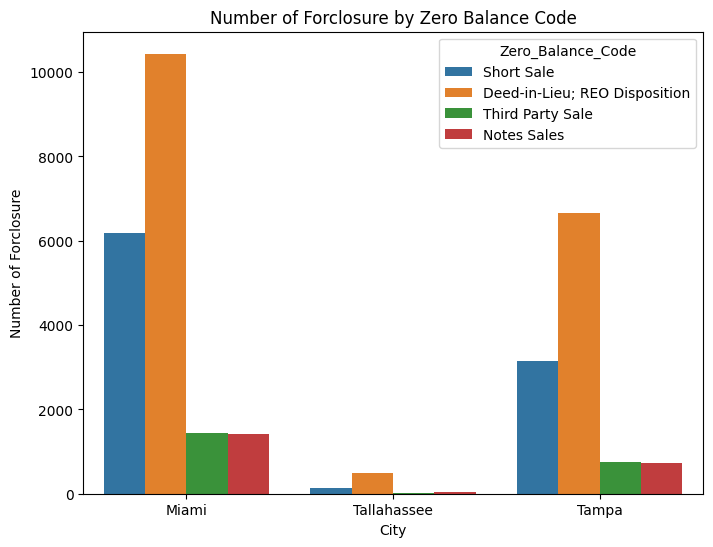

In [ ]:
# Ploting the quantity of orders in each size in each category of the products.
plt.figure(figsize=(8, 6))
sns.countplot(data=cleaned_df, x='City', hue='Zero_Balance_Code')
plt.title('Number of Forclosure by Zero Balance Code')
plt.xlabel('City')
plt.ylabel('Number of Forclosure')
plt.show()


# Hypothesis-2 is false as the zerobalance code of Deed-in-Lieu; REO Disposition is higher in all cities.

# Hypothesis-3: The year 2013 has the highest number of Forclosure

<ipython-input-147-a5cdb2b7eab7>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-147-a5cdb2b7eab7>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



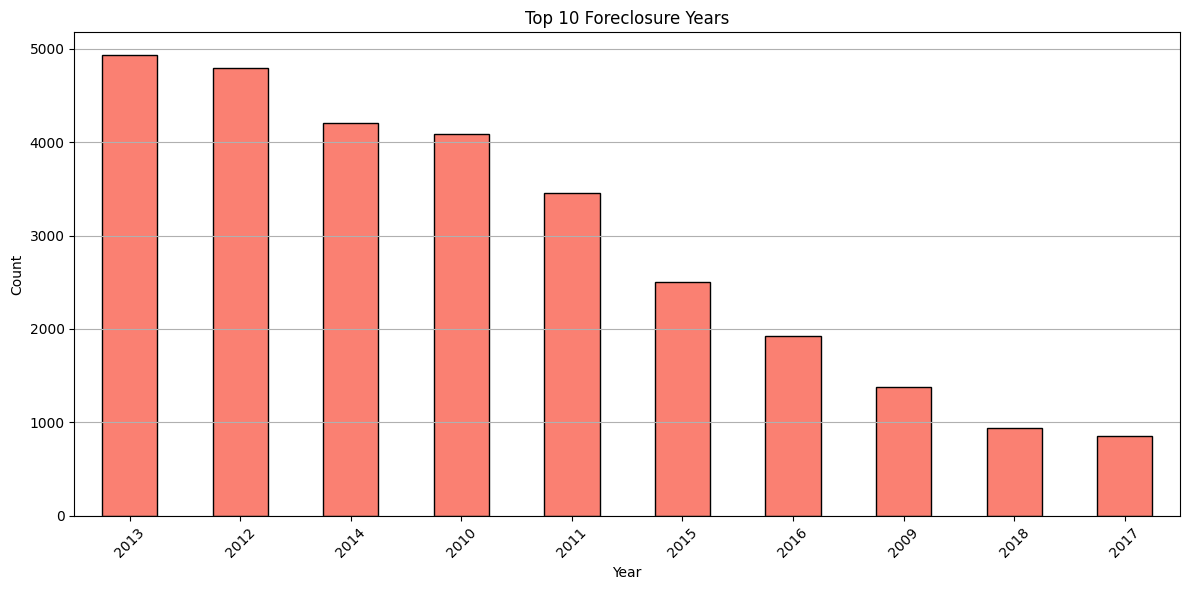

In [ ]:


def plotting_top_10_foreclosure_years(data):
    """
    Plot the top 10 foreclosure years.

    Parameters:
    data (DataFrame): The DataFrame containing the foreclosure data.

    Returns:
    None
    """
    try:
        # Converting 'Foreclosure_date' into datetime format
        data['Foreclosure_date'] = pd.to_datetime(data['Foreclosure_date'], errors='coerce')

        # Extracting the year from the 'Foreclosure_date'
        data['Foreclosure_Year'] = data['Foreclosure_date'].dt.year

        # Dropping rows with NaN values in 'Foreclosure_Year'
        df_year_filtered = data.dropna(subset=['Foreclosure_Year'])

        # Converting 'Foreclosure_Year' to integer
        df_year_filtered['Foreclosure_Year'] = df_year_filtered['Foreclosure_Year'].astype(int)

        # Getting the top 10 foreclosure years
        top_years = df_year_filtered['Foreclosure_Year'].value_counts().sort_values(ascending=False).head(10)

        # Plotting the count for each year
        plt.figure(figsize=(12, 6))
        top_years.plot(kind='bar', color='salmon', edgecolor='black')
        plt.title('Top 10 Foreclosure Years')
        plt.xlabel('Year')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("An error occurred:", e)


    # Calling the foreclosure year plotting function
plotting_top_10_foreclosure_years(cleaned_df)

## Hypothesis-3 is true as the year 2013 has the highest number of forclosures.

# Hypothesis-4: The loan taken for the purpose of refinance has the highest Forclosure cost.

In [ ]:

# Group by Loan_Purpose and calculate the sum of foreclosure costs
loan_purpose_sum = cleaned_df.groupby('Loan_Purpose')['Foreclosure_costs'].sum().reset_index()

# Define a function to plot the bar graph with interactive y-axis scale
@interact
def plot_foreclosure_costs(scale=widgets.Dropdown(options=['linear', 'log'], value='linear', description='Scale:')):
    plt.figure(figsize=(10, 6))
    plt.bar(loan_purpose_sum['Loan_Purpose'], loan_purpose_sum['Foreclosure_costs'], color='salmon')
    plt.title('Sum of Foreclosure Costs by Loan Purpose')
    plt.xlabel('Loan Purpose')
    plt.ylabel('Sum of Foreclosure Costs')
    plt.xticks(rotation=45, ha='right')
    plt.yscale(scale)
    plt.tight_layout()
    plt.show()
    plt.savefig('_sum_foreclosure_costs.png', dpi=300)


interactive(children=(Dropdown(description='Scale:', options=('linear', 'log'), value='linear'), Output()), _d…

<Figure size 640x480 with 0 Axes>

## The hypothesis is false as the loan taken for cash-out Refinance has the highest forclosure cost.

# Hypothesis-5: The highest creditscore of the borrowers for the forclosed loan are almost similar among the three cities.

<ipython-input-149-bb54452755b6>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-149-bb54452755b6>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-149-bb54452755b6>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




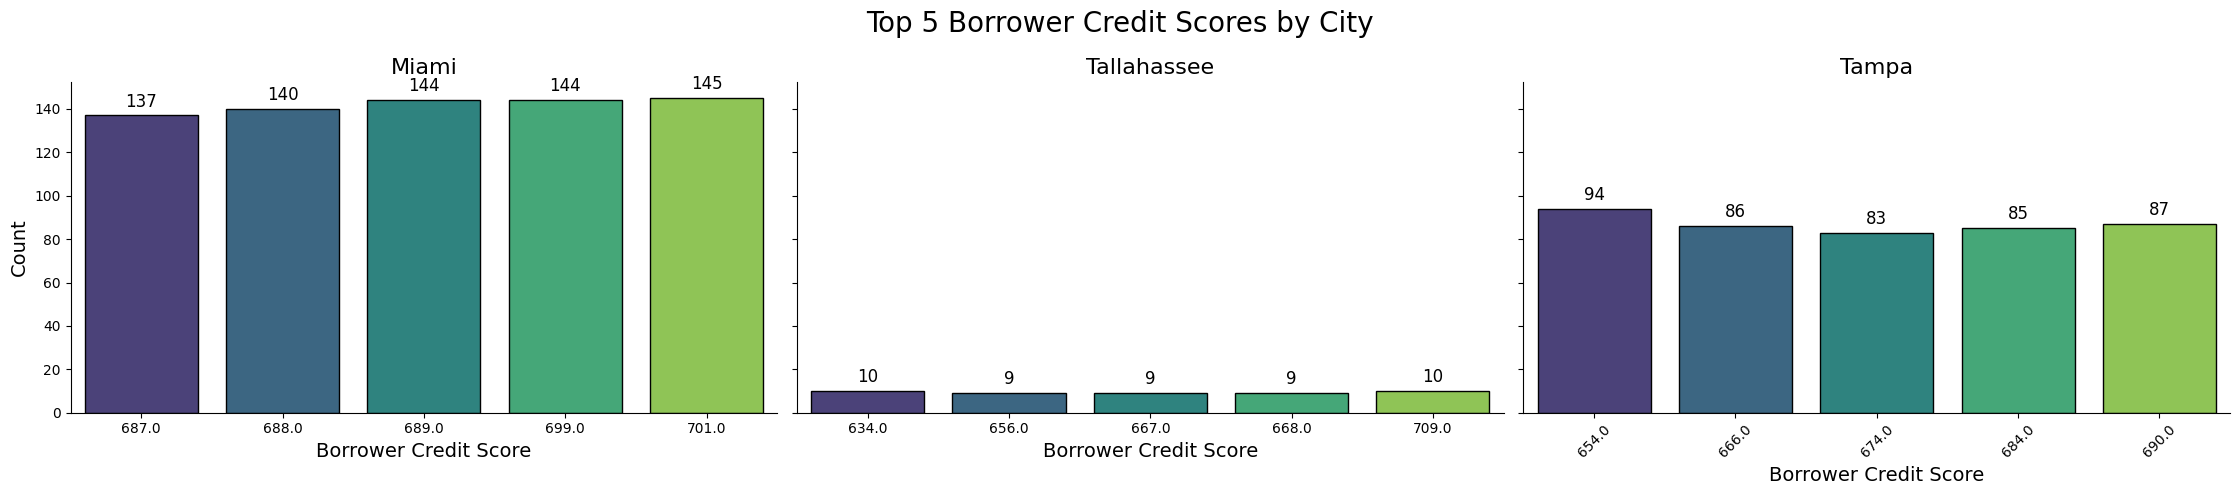

In [ ]:


def top_5_borrower_credit_scores_by_city(data):
    # Filter out rows where Borrower_Credit_Score is 'Unknown'
    filtered_data = data[data['Borrower_Credit_Score'] != 'Unknown']

    # Group by City and Borrower_Credit_Score, then count the occurrences
    grouped = filtered_data.groupby(['City', 'Borrower_Credit_Score']).size().reset_index(name='Count')

    # Sort by City and Count in descending order
    grouped_sorted = grouped.sort_values(['City', 'Count'], ascending=[True, False])

    # Get the top 5 Borrower_Credit_Scores for each city
    top_5_per_city = grouped_sorted.groupby('City').head(5)

    return top_5_per_city

def visualize_top_5_credit_scores(data):
    top_5_data = top_5_borrower_credit_scores_by_city(data)

    # Create a FacetGrid to plot multiple cities
    g = sns.FacetGrid(top_5_data, col='City', col_wrap=3, sharex=False, sharey=True, height=5, aspect=1.5)

    # Define the plotting function
    def barplot(x, y, **kwargs):
        sns.barplot(x=x, y=y, palette='viridis', edgecolor='black', **kwargs)
        for p in plt.gca().patches:
            plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                               ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                               textcoords='offset points')

    # Map the plotting function to the FacetGrid
    g.map(barplot, 'Borrower_Credit_Score', 'Count')

    # Settitles and labels
    g.set_titles(col_template='{col_name}', size=16)
    g.set_axis_labels('Borrower Credit Score', 'Count', size=14)
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('Top 5 Borrower Credit Scores by City', fontsize=20)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

visualize_top_5_credit_scores(cleaned_df)


# The hypothesis is false as there is a 20 credit point difference between the highest borrower credit score for the three cities.

# Hypothesis-6: Analyze whether there is a relationship between loan purpose, origination year, and foreclosure count. Hypothesize that loans taken for certain purposes or originated during specific years have higher foreclosure rates.

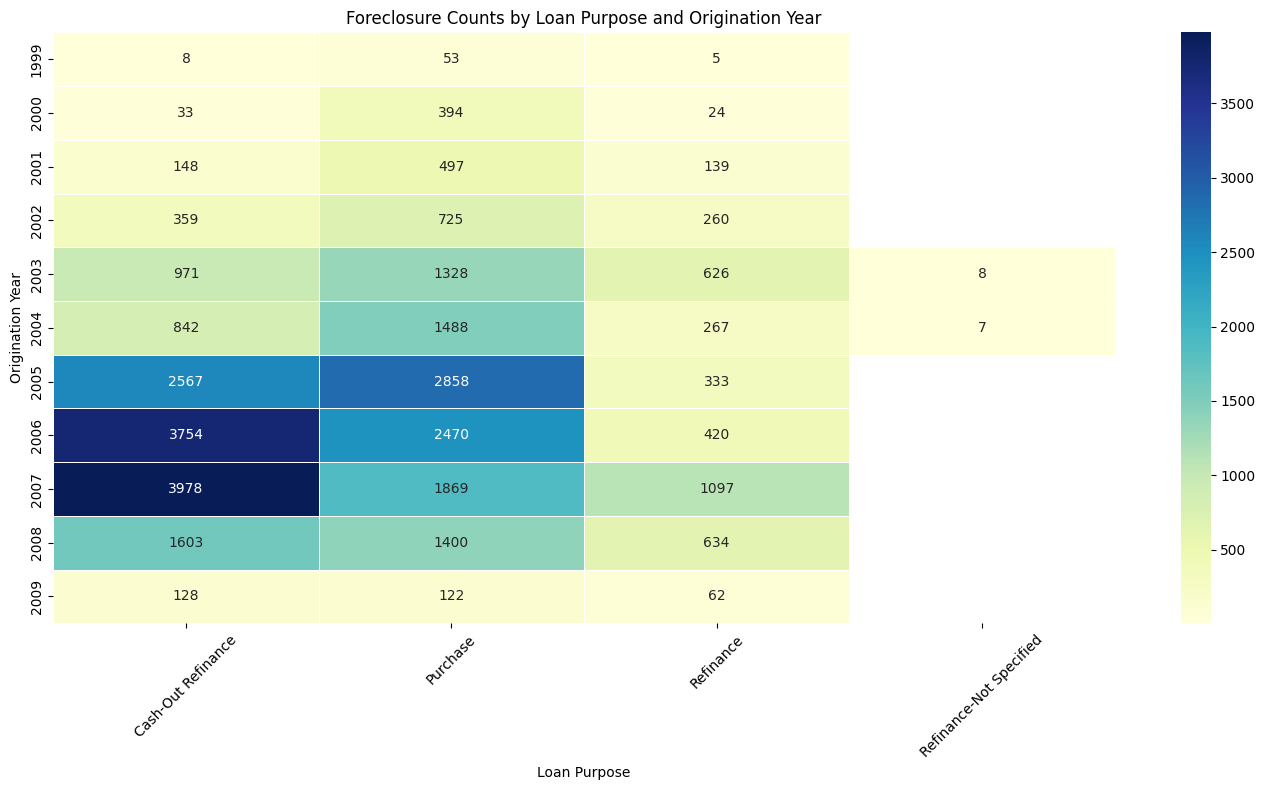

In [ ]:
def analyze_foreclosure_by_loan_purpose_and_year(df):
    """
    Analyzes the relationship between loan purpose, origination year, and foreclosure rates.

    Args:
        df (pandas.DataFrame): The DataFrame containing relevant columns.

    Returns:
        None
    """
    # Filter relevant columns
    filtered_df = df[['OriginationYear', 'Loan_Purpose', 'Foreclosure_date']]

    # Group by loan purpose and origination year, count foreclosures
    foreclosure_counts = filtered_df.groupby(['OriginationYear', 'Loan_Purpose']).size().reset_index(name='Foreclosure_Count')

    # Pivot the data for visualization
    pivot_foreclosure_counts = foreclosure_counts.pivot(index='OriginationYear', columns='Loan_Purpose', values='Foreclosure_Count')

    # Plotting
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot_foreclosure_counts, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5)
    plt.title('Foreclosure Counts by Loan Purpose and Origination Year')
    plt.xlabel('Loan Purpose')
    plt.ylabel('Origination Year')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

analyze_foreclosure_by_loan_purpose_and_year(cleaned_df)


# It seems there is a relationship between the loan origination year and the foreclosure of those loans. It is evident that most of the loans originated during the years 2007, 2006, and 2005 have been foreclosed. This may be due to the immediate 2008 financial crisis combined with various disaster events that happened at that time. Most of the loan taken are for the purpose of cash-out refinance has to be noted.